In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#load dataset
dataset = pd.read_csv('./iris.csv')
dataset.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [3]:
# Overview of Dataset Characteristics
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [4]:
#Summary of N/A Values
dataset.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

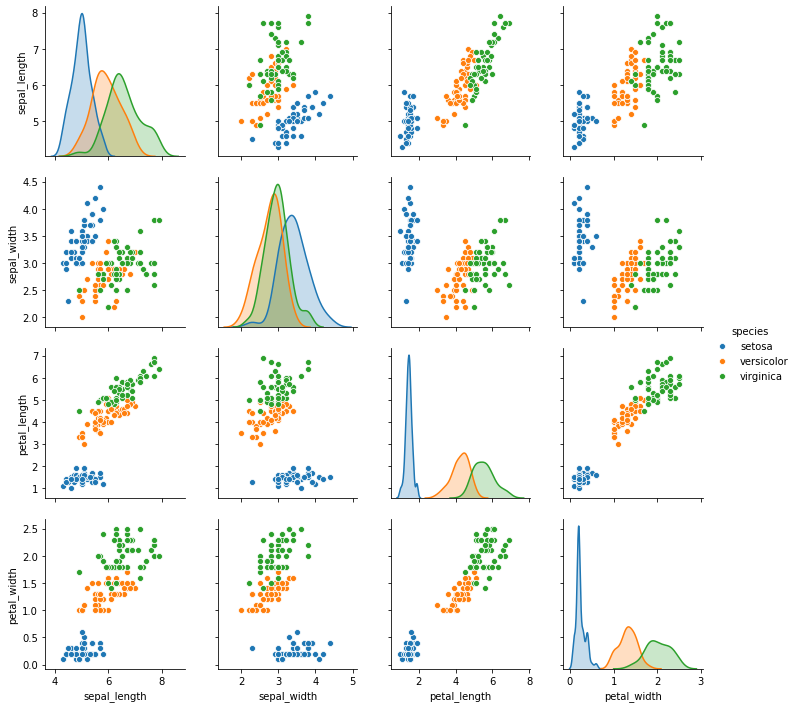

In [5]:
#Visualization of All Variables
pairplot = sns.pairplot(dataset, hue="species")
pairplot

In [6]:
#Review Correlation between Variables
dataset.corr()

sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109369      0.871754     0.817954
sepal_width      -0.109369     1.000000     -0.420516    -0.356544
petal_length      0.871754    -0.420516      1.000000     0.962757
petal_width       0.817954    -0.356544      0.962757     1.000000

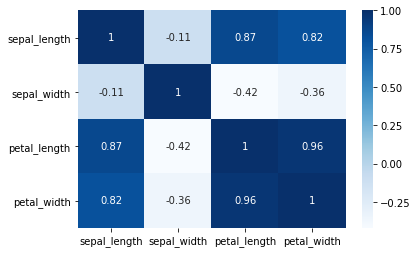

In [7]:
#Visualiztion of Correlations
sns.heatmap(dataset.corr(),annot=True,cmap="Blues")

In [1]:
#Identify Correlated Columns
def correlation(dataset,threshold):
    col_corr=set() # set will contains unique values.
    corr_matrix=dataset.corr() #finding the correlation between columns.
    for i in range(len(corr_matrix.columns)): #number of columns
        print(i)
        for j in range(i):
            print(j)
            if abs(corr_matrix.iloc[i,j])>threshold: #checking the correlation between columns.
                colName=corr_matrix.columns[i] #getting the column name
                col_corr.add(colName) #adding the correlated column name heigher than threshold value.
    return col_corr #returning set of column names
col=correlation(dataset.drop('species', axis=1),0.8)
print('Correlated columns:',col)    

NameError: name 'dataset' is not defined

In [9]:
#Create x and y variables
x = dataset.drop('species', axis=1).values
Y = dataset['species'].values

In [10]:
#Prepare for Models for Comparison

#Load Library for Training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Import Models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

In [11]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe_gnb = Pipeline([('scl', StandardScaler()),
                    ('clf', GaussianNB())])

pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])

pipe_sgd = Pipeline([('scl', StandardScaler()),
                    ('clf', SGDClassifier(max_iter=1000,random_state=100))])

# Set grid search params 
param_range_k = range(1, 10) 

param_gridgnb = {}

param_gridknn = {'clf__n_neighbors':param_range_k}

param_gridsgd = {'clf__loss': ["hinge", "log", "perceptron"],
                 'clf__alpha':[0.001, 0.0001, 0.00001]}

#Optimize Models (Note: GNB has no optimizing paramaters)

opt_gnb = GridSearchCV(estimator=pipe_gnb, param_grid=param_gridgnb,
                       cv=10, verbose=0,scoring='accuracy',n_jobs=-1)

opt_knn = GridSearchCV(estimator=pipe_knn, param_grid=param_gridknn,
                       cv=10, verbose=0,scoring='accuracy',n_jobs=-1)

opt_sgd = GridSearchCV(estimator=pipe_sgd, param_grid=param_gridsgd,
                       cv=10, verbose=0,scoring='accuracy',n_jobs=-1)

# List of pipelines for ease of iteration 
grids = [opt_gnb,opt_knn,opt_sgd] 

# Dictionary of pipelines and classifier types for ease of reference 
grid_dict = {0:'gnb',1: 'kNN', 2: 'SGD'}

In [12]:
#create table to compare MLA metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score
pd.set_option('display.max_colwidth', -1) 
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for idx, gs in enumerate(grids):
    
    #Fit grid search
    gs.fit(x_train, y_train)
    # Predict on test data with best params 
    y_pred2 = gs.predict(x_test) 
    
    #Create Dataframe to Compare Models
    MLA_compare.loc[row_index,'Algorithm Name'] = grid_dict[idx]
    MLA_compare.loc[row_index,'Train Accuracy'] = round(gs.best_score_, 2)
    MLA_compare.loc[row_index,'Precision'] = round(precision_score(y_test, y_pred2,average='weighted'),2)
    MLA_compare.loc[row_index,'Recall'] = round(recall_score(y_test, y_pred2,average='weighted'),2)
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(gs.best_params_)     
    row_index+=1
    
MLA_compare.sort_values(by = ['Precision'], ascending = False, inplace = True)    
MLA_compare

Algorithm Name  Train Accuracy  Precision  Recall  \
2  SGD            0.97            0.93       0.93     
0  gnb            0.98            0.92       0.90     
1  kNN            0.98            0.92       0.90     

                                     MLA Parameters  
2  {'clf__alpha': 0.001, 'clf__loss': 'perceptron'}  
0  {}                                                
1  {'clf__n_neighbors': 7}

In [13]:
#Prediction Dataset
                   
raw_data = {'sepal_length':[7.1],'sepal_width':[4.0],'petal_length':[3.1],
            'petal_width':[1.5]}

dfnew=pd.DataFrame(raw_data, columns = ['sepal_length', 'sepal_width',
                                        'petal_length', 'petal_width'])

dfnew

sepal_length  sepal_width  petal_length  petal_width
0  7.1           4.0          3.1           1.5

In [14]:
#Prediction
print('Prediction GNB:',opt_gnb.predict(dfnew))
print('Prediction kNN:',opt_knn.predict(dfnew))
print('Prediction SGD:',opt_sgd.predict(dfnew))

Prediction GNB: ['versicolor']
Prediction kNN: ['versicolor']
Prediction SGD: ['versicolor']
